# Tutorial: Learning Multiscale PDEs Using Fourier Feature Networks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial13/tutorial.ipynb)

This tutorial demonstrates how to solve a PDE with multiscale behavior using Physics-Informed Neural Networks (PINNs), as discussed in [*On the Eigenvector Bias of Fourier Feature Networks: From Regression to Solving Multi-Scale PDEs with Physics-Informed Neural Networks*](https://doi.org/10.1016/j.cma.2021.113938).

Let’s begin by importing the necessary libraries.


In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import torch
import matplotlib.pyplot as plt
import warnings

from pina import Condition, Trainer
from pina.problem import SpatialProblem
from pina.solver import PINN, SelfAdaptivePINN as SAPINN
from pina.loss import LpLoss
from pina.domain import CartesianDomain
from pina.equation import FixedValue, Poisson
from pina.model import FeedForward
from pina.model.block import FourierFeatureEmbedding

warnings.filterwarnings("ignore")

## Multiscale Problem

We begin by presenting the problem, which is also discussed in Section 2 of [*On the Eigenvector Bias of Fourier Feature Networks: From Regression to Solving Multi-Scale PDEs with Physics-Informed Neural Networks*](https://doi.org/10.1016/j.cma.2021.113938). The one-dimensional Poisson problem we aim to solve is mathematically defined as:

\begin{equation}
\begin{cases}
\Delta u(x) + f(x) = 0 \quad x \in [0,1], \\
u(x) = 0 \quad x \in \partial[0,1],
\end{cases}
\end{equation}

We define the solution as:

$$
u(x) = \sin(2\pi x) + 0.1 \sin(50\pi x),
$$

which leads to the corresponding force term:

$$
f(x) = (2\pi)^2 \sin(2\pi x) + 0.1 (50 \pi)^2 \sin(50\pi x).
$$

While this example is simple and pedagogical, it's important to note that the solution exhibits low-frequency behavior in the macro-scale and high-frequency behavior in the micro-scale. This characteristic is common in many practical scenarios.

Below is the implementation of the `Poisson` problem as described mathematically above.
> **👉 We have a dedicated [tutorial](https://mathlab.github.io/PINA/tutorial16/tutorial.html) to teach how to build a Problem from scratch — have a look if you're interested!**

In [2]:
def forcing_term(x):
    return -(
        ((2 * torch.pi) ** 2) * torch.sin(2 * torch.pi * x)
        + 0.1 * ((50 * torch.pi) ** 2) * torch.sin(50 * torch.pi * x)
    )


poisson_equation = Poisson(forcing_term=forcing_term)


class Poisson(SpatialProblem):
    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [0.0, 1.0]})

    domains = {
        "boundary": spatial_domain.partial(),
        "phys_cond": spatial_domain,
    }

    # here we write the problem conditions
    conditions = {
        "boundary": Condition(domain="boundary", equation=FixedValue(0.0)),
        "phys_cond": Condition(domain="phys_cond", equation=poisson_equation),
    }

    def solution(self, x):
        return torch.sin(2 * torch.pi * x) + 0.1 * torch.sin(50 * torch.pi * x)


problem = Poisson()

# let's discretise the domain
problem.discretise_domain(128, "grid", domains="phys_cond")
problem.discretise_domain(2, "grid", domains="boundary")

A standard PINN approach would involve fitting the model using a Feed Forward (fully connected) Neural Network. For a conventional fully-connected neural network, it is relatively easy to approximate a function $u$, given sufficient data inside the computational domain. 

However, solving high-frequency or multi-scale problems presents significant challenges to PINNs, especially when the number of data points is insufficient to capture the different scales effectively.

Below, we run a simulation using both the `PINN` solver and the self-adaptive `SAPINN` solver, employing a [`FeedForward`](https://mathlab.github.io/PINA/_modules/pina/model/feed_forward.html#FeedForward) model.


In [ ]:
# training with PINN and visualize results
pinn = PINN(
    problem=problem,
    model=FeedForward(
        input_dimensions=1, output_dimensions=1, layers=[100, 100, 100]
    ),
)

trainer = Trainer(
    pinn,
    max_epochs=1500,
    accelerator="cpu",
    enable_model_summary=False,
    val_size=0.0,
    train_size=1.0,
    test_size=0.0,
)
trainer.train()

# training with PINN and visualize results
sapinn = SAPINN(
    problem=problem,
    model=FeedForward(
        input_dimensions=1, output_dimensions=1, layers=[100, 100, 100]
    ),
)
trainer_sapinn = Trainer(
    sapinn,
    max_epochs=1500,
    accelerator="cpu",
    enable_model_summary=False,
    val_size=0.0,
    train_size=1.0,
    test_size=0.0,
)
trainer_sapinn.train()

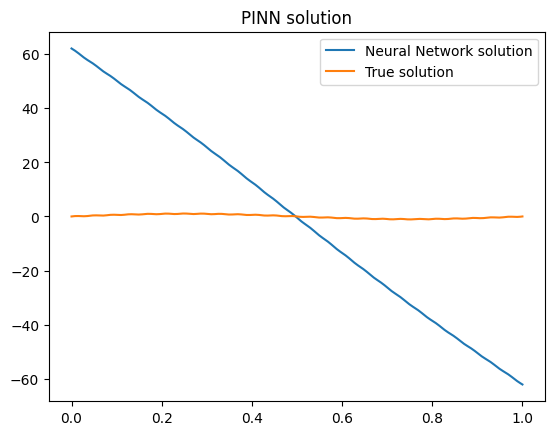

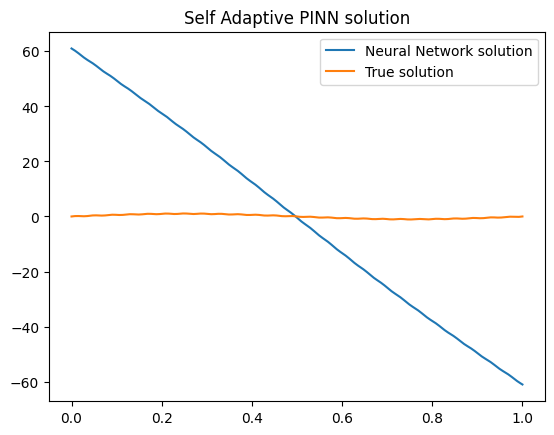

In [4]:
# define the function to plot the solution obtained using matplotlib
def plot_solution(pinn_to_use, title):
    pts = pinn_to_use.problem.spatial_domain.sample(256, "grid", variables="x")
    predicted_output = pinn_to_use(pts).extract("u").tensor.detach()
    true_output = pinn_to_use.problem.solution(pts).detach()
    plt.plot(
        pts.extract(["x"]), predicted_output, label="Neural Network solution"
    )
    plt.plot(pts.extract(["x"]), true_output, label="True solution")
    plt.title(title)
    plt.legend()


# plot the solution of the two PINNs
plot_solution(pinn, "PINN solution")
plt.figure()
plot_solution(sapinn, "Self Adaptive PINN solution")

We can clearly observe that neither of the two solvers has successfully learned the solution.  
The issue is not with the optimization strategy (i.e., the solver), but rather with the model used to solve the problem.  
A simple `FeedForward` network struggles to handle multiscale problems, especially when there are not enough collocation points to capture the different scales effectively.

Next, let's compute the $l_2$ relative error for both the `PINN` and `SAPINN` solutions:

In [5]:
# l2 loss from PINA losses
l2_loss = LpLoss(p=2, relative=False)

# sample new test points
pts = pts = problem.spatial_domain.sample(100, "grid")
print(
    f"Relative l2 error PINN      {l2_loss(pinn(pts), problem.solution(pts)).item():.2%}"
)
print(
    f"Relative l2 error SAPINN    {l2_loss(sapinn(pts), problem.solution(pts)).item():.2%}"
)

Relative l2 error PINN      3143.01%
Relative l2 error SAPINN    3091.39%


Which is indeed very high!

## Fourier Feature Embedding in PINA
Fourier Feature Embedding is a technique used to transform the input features, aiding the network in learning multiscale variations in the output. It was first introduced in [*On the Eigenvector Bias of Fourier Feature Networks: From Regression to Solving Multi-Scale PDEs with Physics-Informed Neural Networks*](https://doi.org/10.1016/j.cma.2021.113938), where it demonstrated excellent results for multiscale problems.

The core idea behind Fourier Feature Embedding is to map the input $\mathbf{x}$ into an embedding $\tilde{\mathbf{x}}$, defined as:

$$
\tilde{\mathbf{x}} = \left[\cos\left( \mathbf{B} \mathbf{x} \right), \sin\left( \mathbf{B} \mathbf{x} \right)\right],
$$

where $\mathbf{B}_{ij} \sim \mathcal{N}(0, \sigma^2)$. This simple operation allows the network to learn across multiple scales!

In **PINA**, we have already implemented this feature as a `layer` called [`FourierFeatureEmbedding`](https://mathlab.github.io/PINA/_rst/layers/fourier_embedding.html). Below, we will build the *Multi-scale Fourier Feature Architecture*. In this architecture, multiple Fourier feature embeddings (initialized with different $\sigma$ values) are applied to the input coordinates. These embeddings are then passed through the same fully-connected neural network, and the outputs are concatenated with a final linear layer.


In [6]:
class MultiscaleFourierNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding1 = FourierFeatureEmbedding(
            input_dimension=1, output_dimension=100, sigma=1
        )
        self.embedding2 = FourierFeatureEmbedding(
            input_dimension=1, output_dimension=100, sigma=10
        )
        self.layers = FeedForward(
            input_dimensions=100, output_dimensions=100, layers=[100]
        )
        self.final_layer = torch.nn.Linear(2 * 100, 1)

    def forward(self, x):
        e1 = self.layers(self.embedding1(x))
        e2 = self.layers(self.embedding2(x))
        return self.final_layer(torch.cat([e1, e2], dim=-1))

We will train the `MultiscaleFourierNet` using the `PINN` solver.  
Feel free to experiment with other PINN variants as well, such as `SAPINN`, `GPINN`, `CompetitivePINN`, and others, to see how they perform on this multiscale problem.

In [ ]:
multiscale_pinn = PINN(problem=problem, model=MultiscaleFourierNet())
trainer = Trainer(
    multiscale_pinn,
    max_epochs=1500,
    accelerator="cpu",
    enable_model_summary=False,
    val_size=0.0,
    train_size=1.0,
    test_size=0.0,
)
trainer.train()

Let us now plot the solution and compute the relative $l_2$ again!

Relative l2 error PINN with MultiscaleFourierNet:   2.47%


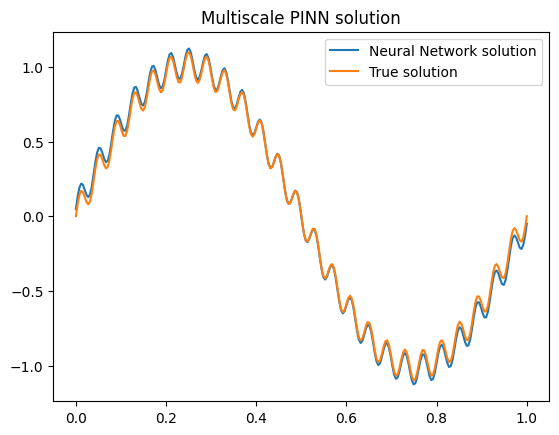

In [8]:
# plot solution obtained
plot_solution(multiscale_pinn, "Multiscale PINN solution")

# sample new test points
pts = pts = problem.spatial_domain.sample(100, "grid")
print(
    f"Relative l2 error PINN with MultiscaleFourierNet:   {l2_loss(multiscale_pinn(pts), problem.solution(pts)).item():.2%}"
)

It is clear that the network has learned the correct solution, with a very low error. Of course, longer training and a more expressive neural network could further improve the results!

## What's Next?

Congratulations on completing the one-dimensional Poisson tutorial of **PINA** using `FourierFeatureEmbedding`! There are many potential next steps you can explore:

1. **Train the network longer or with different layer sizes**: Experiment with different configurations to improve accuracy.

2. **Understand the role of `sigma` in `FourierFeatureEmbedding`**: The original paper provides insightful details on the impact of `sigma`. It's a good next step to dive deeper into its effect.

3. **Implement the *Spatio-temporal Multi-scale Fourier Feature Architecture***: Code this architecture for a more complex, time-dependent PDE (refer to Section 3 of the original paper).

4. **...and many more!**: There are countless directions to further explore, from testing on different problems to refining the model architecture.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).